# Customer Clustering Analysis with K-Means

Phân tích phân khúc khách hàng sử dụng thuật toán K-Means dựa trên dữ liệu RFM (Recency, Frequency, Monetary) và Product Diversity.

## Import Libraries

In [193]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
sns.set_palette("husl")

## Data Loading and Exploration

In [194]:
df = pd.read_csv('Online Retail.csv', delimiter=';')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (348686, 12)


,CustomerID,ProductDiversity,Monetary,Frequency,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,InvoiceDate,Recency
0,12346,1,77183.60,1,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1.04,United Kingdom,2011-01-18 00:00:00,326
1,12747,42,1998.31,11,537215,85124C,GREEN JUICY FRUIT PHOTO FRAME,12,2.55,United Kingdom,2010-12-05 00:00:00,370
2,12747,42,1998.31,11,537215,85124B,BLUE JUICY FRUIT PHOTO FRAME,6,2.55,United Kingdom,2010-12-05 00:00:00,370
3,12747,42,1998.31,11,537215,84879,ASSORTED COLOUR BIRD ORNAMENT,16,1.69,United Kingdom,2010-12-05 00:00:00,370
4,12747,42,1998.31,11,537215,85062,PEARL CRYSTAL PUMPKIN T-LIGHT HLDR,24,1.65,United Kingdom,2010-12-05 00:00:00,370


In [195]:
rfm_df = df.groupby('CustomerID').agg({
    'Recency': 'first', 
    'Frequency': 'first', 
    'Monetary': 'first',  
    'ProductDiversity': 'first' 
}).reset_index()

rfm_df.head()

,CustomerID,Recency,Frequency,Monetary,ProductDiversity
0,12346,326,1,77183.60,1
1,12747,370,11,1998.31,42
2,12748,374,209,11534.84,1763
3,12749,214,5,1428.57,160
4,12820,327,4,394.71,55


## RFM Analysis

RFM Statistics:
           Recency    Frequency       Monetary  ProductDiversity
count  3920.000000  3920.000000    3920.000000       3920.000000
mean    224.085714     4.245663     943.781478         60.647704
std     118.037855     7.194673    4880.324734         81.501573
min       2.000000     1.000000       3.750000          1.000000
25%     113.000000     1.000000     202.252500         15.000000
50%     250.000000     2.000000     399.410000         35.000000
75%     328.000000     5.000000     791.302500         77.000000
max     374.000000   209.000000  168472.500000       1763.000000

Top 10 Products by Quantity:
 1. PAPER CRAFT , LITTLE BIRDIE... : 80,995 units
 2. MEDIUM CERAMIC TOP STORAGE JAR... : 76,919 units
 3. WORLD WAR 2 GLIDERS ASSTD DESIGNS... : 49,086 units
 4. JUMBO BAG RED RETROSPOT... : 41,878 units
 5. WHITE HANGING HEART T-LIGHT HOLDER... : 34,630 units
 6. ASSORTED COLOUR BIRD ORNAMENT... : 32,628 units
 7. POPCORN HOLDER... : 28,923 units
 8. PACK OF 12 LON

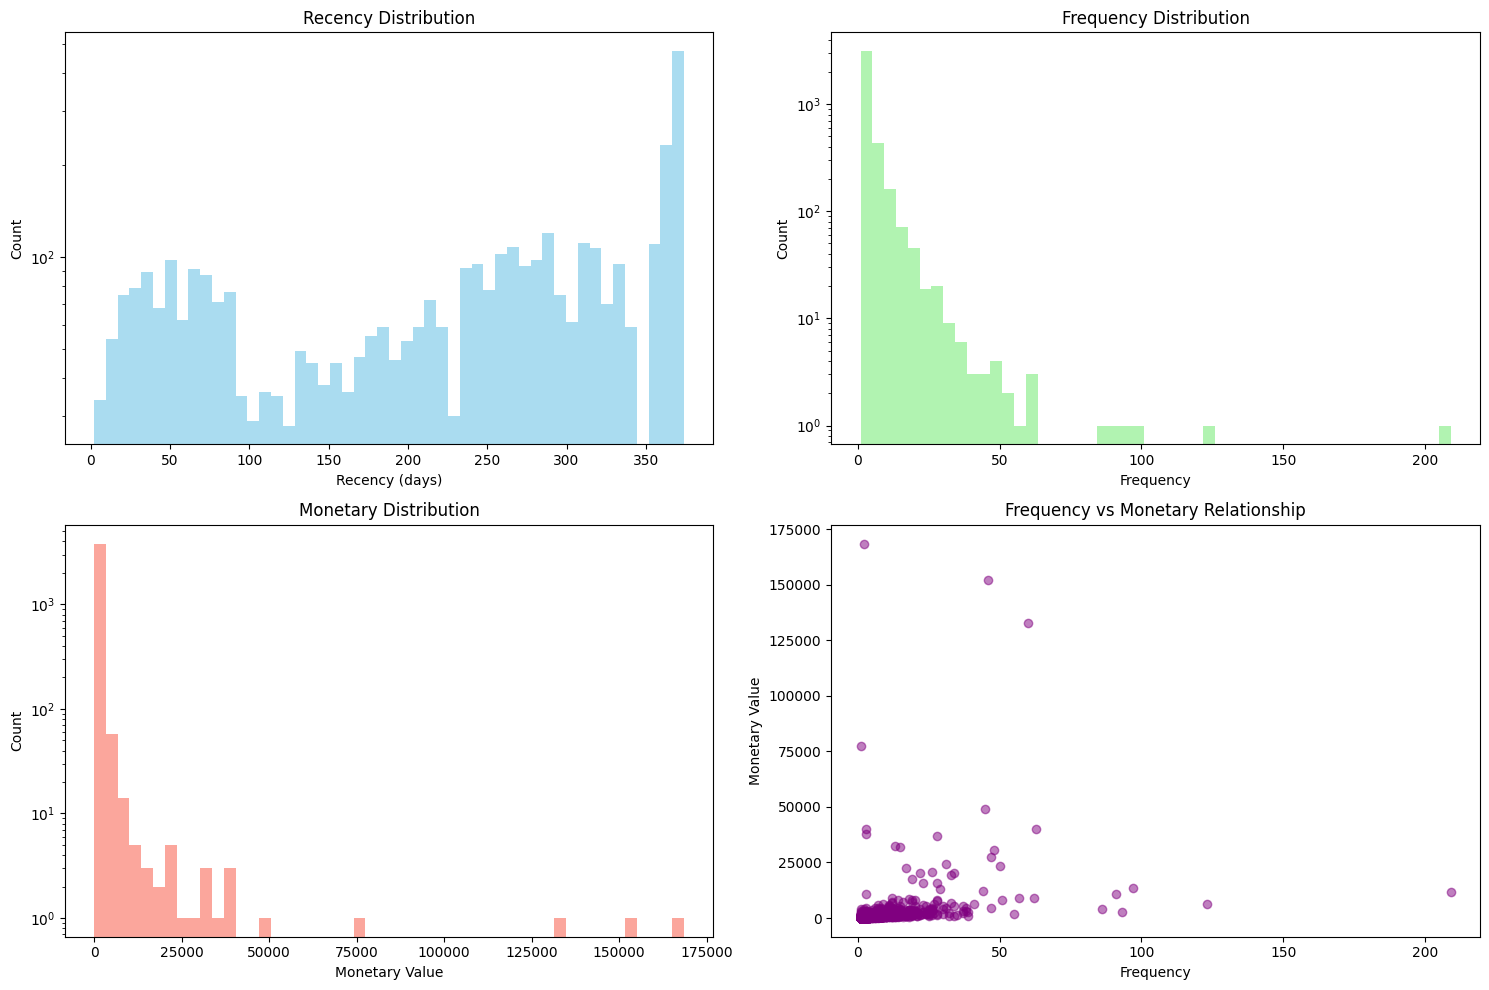

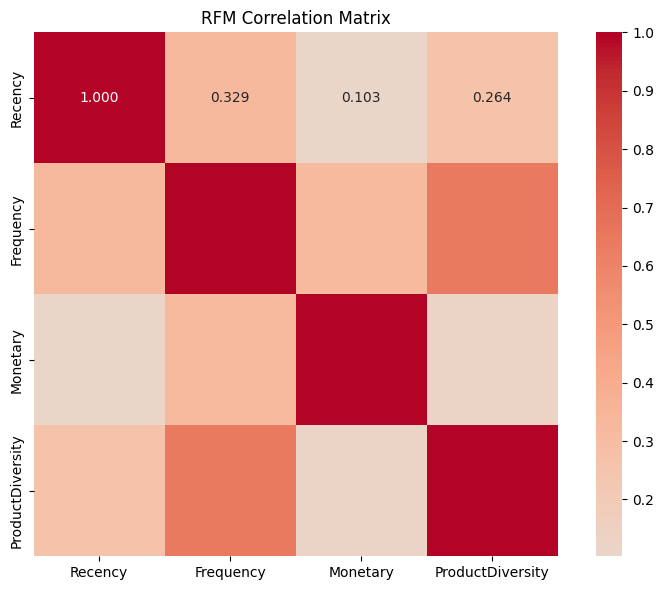

In [196]:
# Basic statistics
print("RFM Statistics:")
print(rfm_df[['Recency', 'Frequency', 'Monetary', 'ProductDiversity']].describe())

# Top products analysis
print("\nTop 10 Products by Quantity:")
top_products_quantity = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
for i, (product, qty) in enumerate(top_products_quantity.items(), 1):
    print(f"{i:2d}. {product[:50]}... : {qty:,} units")

# Revenue calculation
df['Revenue'] = df['Quantity'] * df['UnitPrice']
print("\nTop 10 Products by Revenue:")
top_products_revenue = df.groupby('Description')['Revenue'].sum().sort_values(ascending=False).head(10)
for i, (product, revenue) in enumerate(top_products_revenue.items(), 1):
    print(f"{i:2d}. {product[:50]}... : ${revenue:,.2f}")

# Correlation analysis
correlation = rfm_df['Frequency'].corr(rfm_df['Monetary'])
print(f"\nFrequency vs Monetary Correlation: {correlation:.3f}")

# Correlation matrix
correlation_matrix = rfm_df[['Recency', 'Frequency', 'Monetary', 'ProductDiversity']].corr()
print("\nRFM Correlation Matrix:")
print(correlation_matrix.round(3))

# RFM Distribution visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Recency distribution (log scale)
axes[0, 0].hist(rfm_df['Recency'], bins=50, alpha=0.7, color='skyblue')
axes[0, 0].set_xlabel('Recency (days)')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Recency Distribution')
axes[0, 0].set_yscale('log')

# Frequency distribution (log scale)
axes[0, 1].hist(rfm_df['Frequency'], bins=50, alpha=0.7, color='lightgreen')
axes[0, 1].set_xlabel('Frequency')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Frequency Distribution')
axes[0, 1].set_yscale('log')

# Monetary distribution (log scale)
axes[1, 0].hist(rfm_df['Monetary'], bins=50, alpha=0.7, color='salmon')
axes[1, 0].set_xlabel('Monetary Value')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Monetary Distribution')
axes[1, 0].set_yscale('log')

# Frequency vs Monetary relationship
axes[1, 1].scatter(rfm_df['Frequency'], rfm_df['Monetary'], alpha=0.5, color='purple')
axes[1, 1].set_xlabel('Frequency')
axes[1, 1].set_ylabel('Monetary Value')
axes[1, 1].set_title('Frequency vs Monetary Relationship')

plt.tight_layout()
plt.show()

# RFM Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f')
plt.title('RFM Correlation Matrix')
plt.tight_layout()
plt.show()

## Data Standardization


Before standardization:
           Recency    Frequency       Monetary  ProductDiversity
count  3920.000000  3920.000000    3920.000000       3920.000000
mean    224.085714     4.245663     943.781478         60.647704
std     118.037855     7.194673    4880.324734         81.501573
min       2.000000     1.000000       3.750000          1.000000
25%     113.000000     1.000000     202.252500         15.000000
50%     250.000000     2.000000     399.410000         35.000000
75%     328.000000     5.000000     791.302500         77.000000
max     374.000000   209.000000  168472.500000       1763.000000

After standardization:
            Recency     Frequency      Monetary  ProductDiversity
count  3.920000e+03  3.920000e+03  3.920000e+03      3.920000e+03
mean  -2.673598e-17  9.063045e-18 -9.063045e-18      1.178196e-17
std    1.000128e+00  1.000128e+00  1.000128e+00      1.000128e+00
min   -1.881719e+00 -4.511779e-01 -1.926412e-01     -7.319529e-01
25%   -9.412225e-01 -4.511779e-01 -1

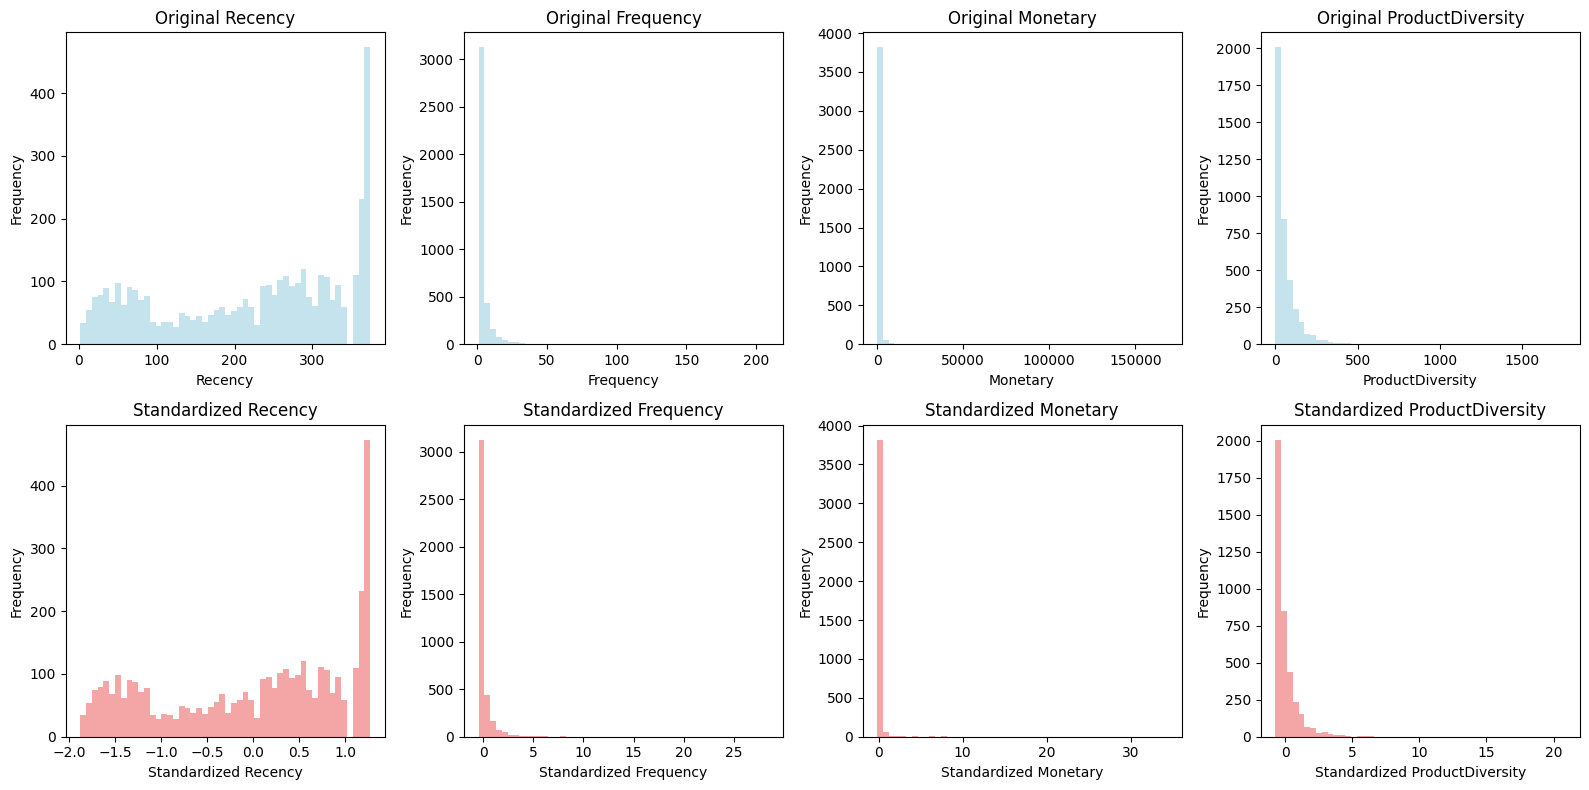

In [197]:
features_for_clustering = ['Recency', 'Frequency', 'Monetary', 'ProductDiversity']
X = rfm_df[features_for_clustering].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_scaled_df = pd.DataFrame(X_scaled, columns=features_for_clustering)

print("\nBefore standardization:")
print(X.describe())
print("\nAfter standardization:")
print(X_scaled_df.describe())

# Visualize standardization comparison
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for i, feature in enumerate(features_for_clustering):
    # Original data
    axes[0, i].hist(X[feature], bins=50, alpha=0.7, color='lightblue')
    axes[0, i].set_title(f'Original {feature}')
    axes[0, i].set_xlabel(feature)
    axes[0, i].set_ylabel('Frequency')
    
    # Standardized data
    axes[1, i].hist(X_scaled[:, i], bins=50, alpha=0.7, color='lightcoral')
    axes[1, i].set_title(f'Standardized {feature}')
    axes[1, i].set_xlabel(f'Standardized {feature}')
    axes[1, i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Determine Optimal Number of Clusters

K=2: Inertia=12028.57, Silhouette Score=0.380
K=3: Inertia=8964.59, Silhouette Score=0.411
K=4: Inertia=6504.77, Silhouette Score=0.453
K=5: Inertia=4923.71, Silhouette Score=0.459
K=6: Inertia=4188.69, Silhouette Score=0.435
K=7: Inertia=3555.87, Silhouette Score=0.433
K=8: Inertia=3186.84, Silhouette Score=0.366
K=9: Inertia=2833.16, Silhouette Score=0.366
K=10: Inertia=2511.66, Silhouette Score=0.376

Optimal number of clusters (based on trên Silhouette Score): 5


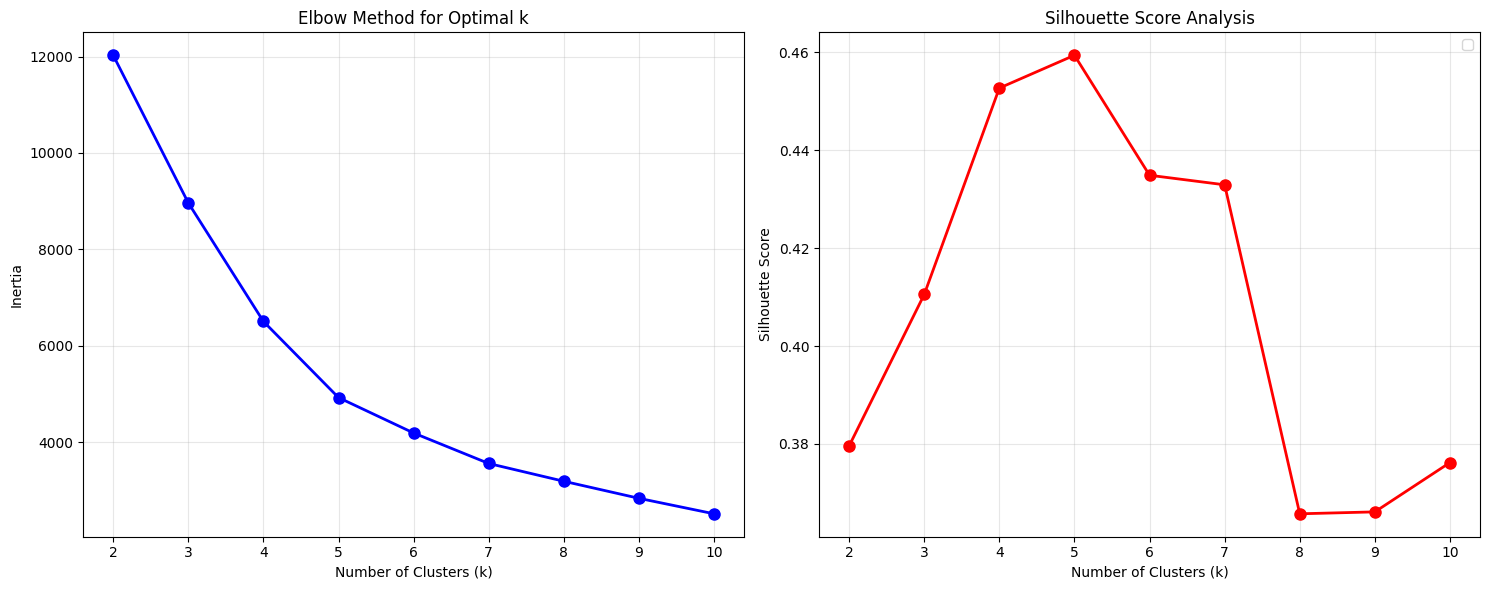

In [198]:
def elbow_method(X, max_k=10):
    inertias = []
    silhouette_scores = []
    K_range = range(2, max_k + 1)
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))
    
    return K_range, inertias, silhouette_scores

K_range, inertias, silhouette_scores = elbow_method(X_scaled, max_k=10)

for k, inertia, sil_score in zip(K_range, inertias, silhouette_scores):
    print(f"K={k}: Inertia={inertia:.2f}, Silhouette Score={sil_score:.3f}")

# Tìm k tối ưu dựa trên Silhouette Score
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\nOptimal number of clusters (based on trên Silhouette Score): {optimal_k}")

# Visualization cho Elbow Method và Silhouette Analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Elbow plot
ax1.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method for Optimal k')
ax1.grid(True, alpha=0.3)

# Silhouette score plot
ax2.plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score Analysis')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## K-Means Clustering Implementation

In [199]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

rfm_df['KMeans_Cluster'] = kmeans_labels

print(f"\nClusters distribution:")
cluster_counts = pd.Series(kmeans_labels).value_counts().sort_index()
for cluster, count in cluster_counts.items():
    percentage = (count / len(kmeans_labels)) * 100
    print(f"Cluster {cluster}: {count} customers ({percentage:.1f}%)")

kmeans_centroids_original = scaler.inverse_transform(kmeans.cluster_centers_)
centroids_df = pd.DataFrame(kmeans_centroids_original, 
                           columns=features_for_clustering)
centroids_df.index.name = 'Cluster'
centroids_df = centroids_df.round(0).astype(int)

print(f"\nCentroids of clusters:")
print(centroids_df)


Clusters distribution:
Cluster 0: 4 customers (0.1%)
Cluster 1: 2078 customers (53.0%)
Cluster 2: 5 customers (0.1%)
Cluster 3: 1439 customers (36.7%)
Cluster 4: 394 customers (10.1%)

Centroids of clusters:
         Recency  Frequency  Monetary  ProductDiversity
Cluster                                                
0            317         27    132663                70
1            298          4       665                48
2            373        123      8992              1017
3             88          2       377                34
4            329         15      3038               211

Cluster 0: 4 customers (0.1%)
Cluster 1: 2078 customers (53.0%)
Cluster 2: 5 customers (0.1%)
Cluster 3: 1439 customers (36.7%)
Cluster 4: 394 customers (10.1%)

Centroids of clusters:
         Recency  Frequency  Monetary  ProductDiversity
Cluster                                                
0            317         27    132663                70
1            298          4       665        

## K-Means Clustering Evaluation

In [200]:
silhouette = silhouette_score(X_scaled, kmeans_labels)
calinski_harabasz = calinski_harabasz_score(X_scaled, kmeans_labels)
davies_bouldin = davies_bouldin_score(X_scaled, kmeans_labels)

print(f"Silhouette Score: {silhouette:.3f}")
print(f"Calinski-Harabasz Score: {calinski_harabasz:.2f}")
print(f"Davies-Bouldin Score: {davies_bouldin:.3f}")

if silhouette > 0.5:
    print("\nClustering quality: Good")
elif silhouette > 0.3:
    print("\nClustering quality: Medium")
else:
    print("\nClustering quality: Need to be improved")

Silhouette Score: 0.459
Calinski-Harabasz Score: 2138.18
Davies-Bouldin Score: 0.743

Clustering quality: Medium


## Visualize K-Means Clustering Results

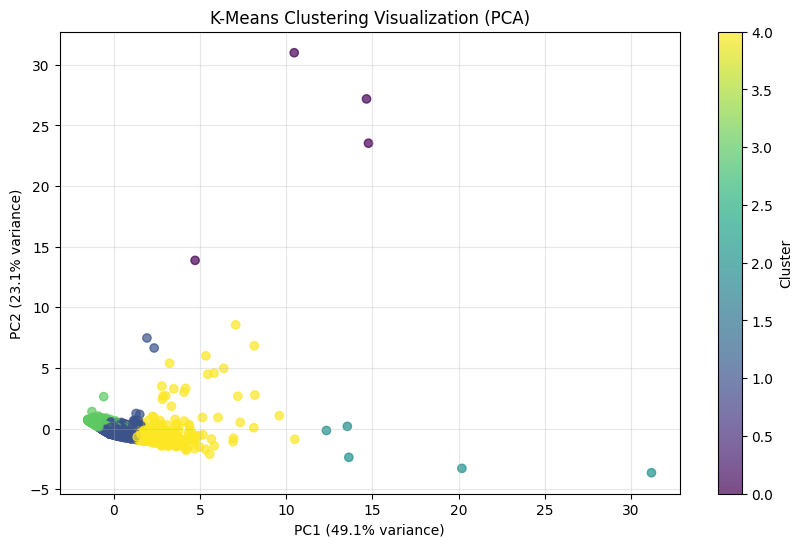

In [201]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Cluster')
plt.title('K-Means Clustering Visualization (PCA)')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.grid(True, alpha=0.3)
plt.show()

## Extract Business Insights from K-Means Clusters

Business insights
               Recency               Frequency                 Monetary  \
                  mean median    std      mean median    std       mean   
KMeans_Cluster                                                            
0               317.00  347.0  76.60     27.25   24.0  30.28  132662.71   
1               298.00  297.0  54.56      3.58    3.0   2.76     665.29   
2               373.20  374.0   1.79    122.60   97.0  49.99    8991.71   
3                87.93   76.0  54.78      1.80    1.0   1.28     376.67   
4               328.70  361.0  63.87     14.94   12.0  10.72    3044.45   

                                    ProductDiversity                 
                   median       std             mean median     std  
KMeans_Cluster                                                       
0               142497.37  39767.33            69.50   63.5   78.67  
1                  440.82   1374.20            47.97   37.0   39.22  
2                10696.29   442

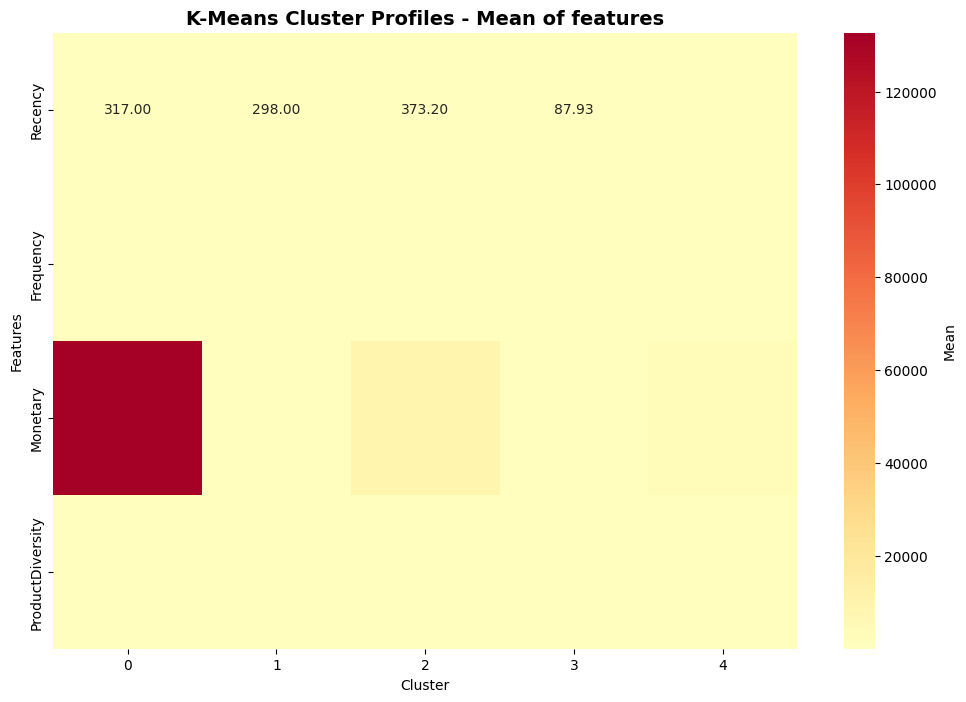

In [202]:
print("Business insights")

cluster_profiles = rfm_df.groupby('KMeans_Cluster').agg({
    'Recency': ['mean', 'median', 'std'],
    'Frequency': ['mean', 'median', 'std'], 
    'Monetary': ['mean', 'median', 'std'],
    'ProductDiversity': ['mean', 'median', 'std']
}).round(2)

print(cluster_profiles)

cluster_means = rfm_df.groupby('KMeans_Cluster')[features_for_clustering].mean()

plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means.T, annot=True, fmt='.2f', cmap='RdYlBu_r', center=0,
            cbar_kws={'label': 'Mean'})
plt.title('K-Means Cluster Profiles - Mean of features', fontsize=14, fontweight='bold')
plt.xlabel('Cluster')
plt.ylabel('Features')
plt.show()

In [203]:
cluster_profiles = rfm_df.groupby('KMeans_Cluster')[features_for_clustering].mean().round(1)
for cluster in sorted(rfm_df['KMeans_Cluster'].unique()):
    cluster_data = rfm_df[rfm_df['KMeans_Cluster'] == cluster]
    size = len(cluster_data)
    percentage = (size / len(rfm_df)) * 100
    
    print(f"\nCLUSTER {cluster} ({size:,} customers - {percentage:.1f}%)")
    print(f"   Recency: {cluster_profiles.loc[cluster, 'Recency']:.0f} days")
    print(f"   Frequency: {cluster_profiles.loc[cluster, 'Frequency']:.1f} times")
    print(f"   Monetary: ${cluster_profiles.loc[cluster, 'Monetary']:,.0f}")
    print(f"   Product Diversity: {cluster_profiles.loc[cluster, 'ProductDiversity']:.1f}")

print("\n\nBUSINESS RECOMMENDATIONS")
print("=" * 40)
for cluster in sorted(rfm_df['KMeans_Cluster'].unique()):
    recency = cluster_profiles.loc[cluster, 'Recency']
    frequency = cluster_profiles.loc[cluster, 'Frequency'] 
    monetary = cluster_profiles.loc[cluster, 'Monetary']
    
    print(f"\nCluster {cluster}:")
    if recency < 50 and monetary > rfm_df['Monetary'].median():
        print("   VIP customers - continue premium service")
    elif recency > 200:
        print("   Win-back campaign - Email remarketing")
    elif frequency < 2:
        print("   New customer nurturing - Onboarding programs")
    else:
        print("   Regular engagement - Loyalty programs")


CLUSTER 0 (4 customers - 0.1%)
   Recency: 317 days
   Frequency: 27.2 times
   Monetary: $132,663
   Product Diversity: 69.5

CLUSTER 1 (2,078 customers - 53.0%)
   Recency: 298 days
   Frequency: 3.6 times
   Monetary: $665
   Product Diversity: 48.0

CLUSTER 2 (5 customers - 0.1%)
   Recency: 373 days
   Frequency: 122.6 times
   Monetary: $8,992
   Product Diversity: 1017.0

CLUSTER 3 (1,439 customers - 36.7%)
   Recency: 88 days
   Frequency: 1.8 times
   Monetary: $377
   Product Diversity: 34.4

CLUSTER 4 (394 customers - 10.1%)
   Recency: 329 days
   Frequency: 14.9 times
   Monetary: $3,044
   Product Diversity: 211.0


BUSINESS RECOMMENDATIONS

Cluster 0:
   Win-back campaign - Email remarketing

Cluster 1:
   Win-back campaign - Email remarketing

Cluster 2:
   Win-back campaign - Email remarketing

Cluster 3:
   New customer nurturing - Onboarding programs

Cluster 4:
   Win-back campaign - Email remarketing


In [204]:
total_customers = len(rfm_df)
clusters_count = len(rfm_df['KMeans_Cluster'].unique())

print(f"K-Means clustering {total_customers:,} customers to {clusters_count} clusters")
print(f"Silhouette Score: {silhouette:.3f} - Medium")

highest_value_cluster = cluster_profiles['Monetary'].idxmax()
vip_size = len(rfm_df[rfm_df['KMeans_Cluster'] == highest_value_cluster])
vip_percentage = (vip_size / total_customers) * 100

print(f"\nKEY INSIGHTS:")
print(f"Cluster {highest_value_cluster}: VIP segment ({vip_size:,} customer, {vip_percentage:.1f}%)")
print(f"Average revenue per VIP: ${cluster_profiles.loc[highest_value_cluster, 'Monetary']:,.0f}")
print(f"Recommended focus: Retention & premium services")

K-Means clustering 3,920 customers to 5 clusters
Silhouette Score: 0.459 - Medium

KEY INSIGHTS:
Cluster 0: VIP segment (4 customer, 0.1%)
Average revenue per VIP: $132,663
Recommended focus: Retention & premium services
